# Darts

Experiment for doing forecasting of wind power prediction with darts

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler
# pylint: disable=import-error
from src.dataset import get_df_from_bucket

In [10]:
os.environ["EMAP_PROJECT_ID"]="tmrow-152415"
os.environ["POSTGRES_DB"]="electricitymap"
os.environ["POSTGRES_HOST"]="127.0.0.1"
os.environ["POSTGRES_USER"]="readonly"
os.environ["POSTGRES_PORT"]="5432"

rcParams['figure.figsize'] = (10, 4)

---

Get data

In [11]:
zone_keys = ["DK-DK1", "ES", "US-CENT-SWPP"]

df = get_df_from_bucket(zone_keys[0])
df = df.drop(columns=["zone_key"])
# Get rid of timezone info
df.index = df.index.tz_convert(None).to_pydatetime()

In [12]:
df.power_production_wind_avg.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 12120 entries, 2021-01-01 00:00:00 to 2022-05-20 23:00:00
Series name: power_production_wind_avg
Non-Null Count  Dtype  
--------------  -----  
12120 non-null  float64
dtypes: float64(1)
memory usage: 189.4 KB


<AxesSubplot:xlabel='time'>

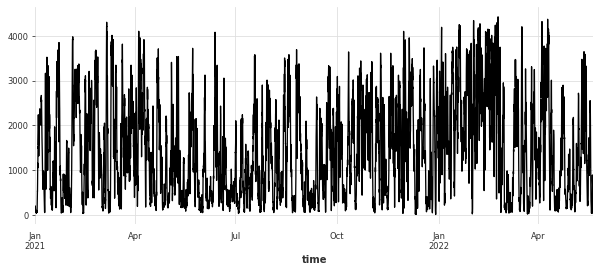

In [42]:
df.power_production_wind_avg.plot()

In [45]:
df.loc[:, "latest_forecasted_wind_avg"] = np.sqrt(df.latest_forecasted_wind_x_avg**2 + df.latest_forecasted_wind_y_avg**2)
df = df.drop(columns=["latest_forecasted_wind_x_avg", "latest_forecasted_wind_y_avg"])

In [46]:
df.columns

Index(['power_production_wind_avg', 'power_production_solar_avg',
       'latest_forecasted_solar_avg', 'latest_forecasted_dewpoint_avg',
       'latest_forecasted_temperature_avg',
       'latest_forecasted_precipitation_avg',
       'latest_forecasted_production_wind_avg',
       'latest_forecasted_production_solar_avg', 'latest_forecasted_wind_avg'],
      dtype='object')

In [47]:
ts_col = ["power_production_wind_avg", "power_production_solar_avg"]
covariates_col = [
    "latest_forecasted_production_wind_avg",
    "latest_forecasted_production_solar_avg",
    "latest_forecasted_solar_avg",
    "latest_forecasted_wind_avg",
    "latest_forecasted_dewpoint_avg",
    "latest_forecasted_temperature_avg",
    "latest_forecasted_precipitation_avg"
]

In [53]:
ts = TimeSeries.from_dataframe(df[ts_col])
ts = Scaler().fit_transform(ts)
train, test = ts.split_before(0.75)

ts_covariates = TimeSeries.from_dataframe(df[covariates_col].fillna(method="ffill"))
ts_covariates = Scaler().fit_transform(ts_covariates)

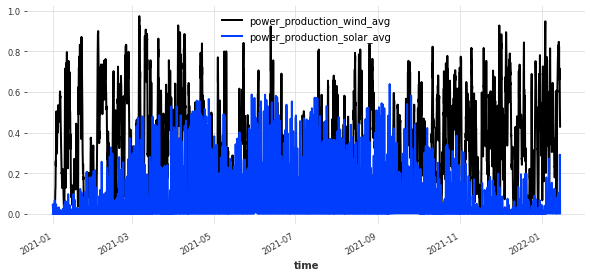

In [49]:
train.plot()

In [50]:
def eval_model(model):
    model.fit(train.univariate_component("power_production_wind_avg"))
    forecast = model.predict(len(test))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(test.univariate_component("power_production_wind_avg"), forecast)))

In [51]:
# eval_model(ExponentialSmoothing())
# eval_model(Prophet())
# eval_model(AutoARIMA())
# eval_model(Theta())

In [54]:
model = AutoARIMA()
model.fit(train.univariate_component("power_production_wind_avg"), future_covariates=ts_covariates)
forecast = model.predict(len(test), future_covariates=ts_covariates)

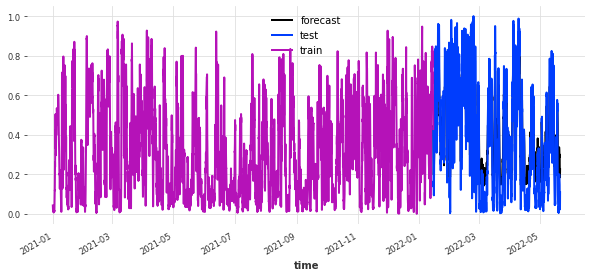

In [55]:
forecast.plot(label="forecast")
test.univariate_component("power_production_wind_avg").plot(label="test")
train.univariate_component("power_production_wind_avg").plot(label="train")

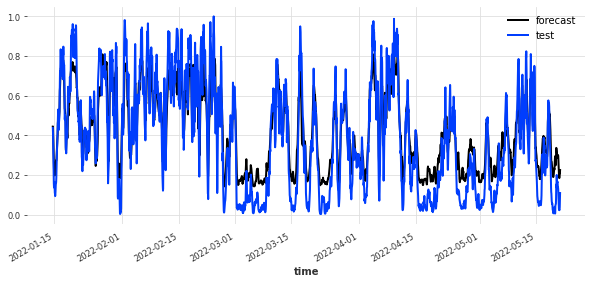

In [58]:
forecast["2022-05-01":].plot(label="forecast")
test.univariate_component("power_production_wind_avg")["2022-05-01":].plot(label="test")